# 5-7. 프로젝트: Spectrogram classification 모델 구현

### [루브릭]

평가문항	상세기준
   1. 음성데이터를 2차원 Spectrogram 으로 변환하여 데이터셋을 구성하였다.  
        -스펙트로그램 시각화 및 train/test 데이터셋 구성이 정상진행되었다.
    
    
   2. 1,2차원 데이터를 처리하는 음성인식 모델이 정상 작동한다.  
        -스펙트로그램을 입력받은 모델이 학습과정에서 안정적으로 수렴하며, evaluation/test 단계를 무리없이 진행가능하다.
    
    
   3. 테스트셋 수행결과 음성인식 모델의 Accuracy가 일정 수준에 도달하였다.  
        -evaluation 결과 75% 이상의 정확도를 달성하는 모델이 하나 이상 존재한다.
    
    
### [학습 과정]
1. 데이터 처리와 분류
2. 학습을 위한 하이퍼파라미터 설정
3. 데이터셋 구성
4. 2차원 Spectrogram 데이터를 처리하는 모델 구성
5. 학습 후, 학습이 어떻게 진행됐는지 그래프로 출력
6. Test dataset을 이용해서 모델의 성능을 평가

### [결론 및 회고]

---
### 데이터 처리와 분류
* 라벨 데이터 처리하기
* sklearn의 train_test_split함수를 이용하여 train, test 분리

In [1]:
import numpy as np
import os

data_path = os.getenv("HOME")+'/aiffel/E05_SpeechToText/data/speech_wav_8000.npz'
speech_data = np.load(data_path)


In [2]:
print("Wave data shape : ", speech_data["wav_vals"].shape)   # data
print("Label data shape : ", speech_data["label_vals"].shape) #features

Wave data shape :  (50620, 8000)
Label data shape :  (50620, 1)


In [3]:
import IPython.display as ipd
import random

sr = 130        # 1초동안 재생되는 샘플의 갯수. sample rate.
sc = 126
rand = random.randint(0, len(speech_data["wav_vals"])) #데이터를 랜덤하게 선택
print("rand num : ", rand)

data = speech_data["wav_vals"][rand]
print("Wave data shape : ", data.shape)
print("label : ", speech_data["label_vals"][rand])

ipd.Audio(data, rate=sr)

rand num :  21957
Wave data shape :  (8000,)
label :  ['down']


In [4]:
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label

In [5]:
import librosa

def wav2spec(wav, fft_size=258): # spectrogram shape을 맞추기위해서 size 변형
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D

In [6]:
# 위에서 뽑았던 sample data
spec = []
for wav in speech_data["wav_vals"][:30000, :]:
    spec.append(wav2spec(wav))
spec = np.array(spec)

print("Waveform shape : ",data.shape)
print("Spectrogram shape : ",spec.shape)

Waveform shape :  (8000,)
Spectrogram shape :  (30000, 130, 126)


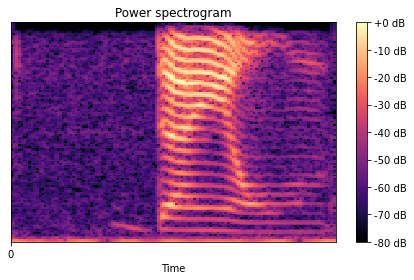

In [7]:
import librosa.display
import matplotlib.pyplot as plt


librosa.display.specshow(librosa.amplitude_to_db(spec[1], ref=np.max), x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.xticks(range(0, 1))
plt.tight_layout()
plt.show()

#### Label data 처리

In [8]:
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

print('LABEL : ', label_value)

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value

print('Indexed LABEL : ', new_label_value)

LABEL :  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']
Indexed LABEL :  {'yes': 0, 'no': 1, 'up': 2, 'down': 3, 'left': 4, 'right': 5, 'on': 6, 'off': 7, 'stop': 8, 'go': 9, 'unknown': 10, 'silence': 11}


In [9]:
temp = []

# Label data를 int로 바꿔주기
for v in speech_data["label_vals"][:30000, :]:
    temp.append(label_value[v[0]])
label_data = np.array(temp)

label_data

array([3, 3, 3, ..., 7, 7, 7])

#### train, test data split

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(spec,
                                                   label_data,
                                                   test_size=0.1,
                                                    shuffle = True)
print(X_train)

X_train = X_train.reshape([-1,sr,sc, 1])  # add channel for CNN
X_test = X_test.reshape([-1, sr, sc, 1])


[[[1.20300762e-02 2.05157027e-01 2.90702462e-01 ... 2.76556134e-01
   1.48491710e-01 4.84412968e-01]
  [3.79706651e-01 4.29175347e-01 1.33054093e-01 ... 2.18391240e-01
   3.60804260e-01 4.44186240e-01]
  [7.45051444e-01 5.71938932e-01 2.63037503e-01 ... 1.20747067e-01
   2.10794583e-01 2.08583832e-01]
  ...
  [1.17156946e-03 8.42028530e-04 4.98605077e-04 ... 5.13097912e-04
   2.84951995e-03 5.30537497e-03]
  [1.22185028e-03 5.15949912e-04 8.45513568e-05 ... 1.86577672e-04
   2.90280115e-03 5.46444254e-03]
  [1.17811759e-03 6.55625598e-04 4.59936346e-05 ... 6.10759234e-05
   2.65394105e-03 5.31238131e-03]]

 [[1.28489118e-02 5.73203666e-03 1.19186263e-03 ... 1.06065654e-05
   4.06933529e-03 1.04264775e-02]
  [1.69052407e-02 7.93491025e-03 2.02437770e-03 ... 3.14299972e-03
   7.31916074e-03 1.11473575e-02]
  [2.14839224e-02 1.45009505e-02 3.73382075e-03 ... 7.97387306e-03
   5.31266863e-03 1.17687024e-02]
  ...
  [4.56382567e-03 2.00305111e-03 5.68802061e-04 ... 5.85087051e-04
   2.39413

In [11]:
print("train data : ",X_train.shape)
print("test data : ", X_test.shape)
print("train labels : ", y_train.shape)
print("test labels : ", y_test.shape)
print("✅")

train data :  (27000, 130, 126, 1)
test data :  (3000, 130, 126, 1)
train labels :  (27000,)
test labels :  (3000,)
✅


### 학습을 위한 하이퍼파라미터 설정

In [12]:
batch_size = 32
max_epochs = 10

# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/E05_SpeechToText/models/wav'

checkpoint_dir

'/home/ssac18/aiffel/E05_SpeechToText/models/wav'

### 데이터셋 구성

In [13]:
import tensorflow as tf

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)


<BatchDataset shapes: ((None, 130, 126, 1), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 130, 126, 1), (None, 12)), types: (tf.float32, tf.float32)>


In [14]:
del speech_data

### 2차원 Spectrogram 데이터를 처리하는 모델 구성
# 1-1. Spectrogram Classification - Conv1D 사용

In [15]:
from tensorflow.keras import layers

input_tensor = layers.Input(shape=(sr, sc))

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_spec = tf.keras.Model(input_tensor, output_tensor)

model_spec.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 130, 126)]        0         
_________________________________________________________________
conv1d (Conv1D)              (None, 130, 32)           36320     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 130, 32)           9248      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 65, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 65, 64)            18496     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 65, 64)            36928     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 32, 64)            0     

In [16]:
# Loss
optimizer=tf.keras.optimizers.Adam(1e-4)
model_spec.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])

In [17]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

In [18]:
history_spec = model_spec.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(X_train) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(X_test) // batch_size,
                    callbacks=[cp_callback]
                    )

Epoch 1/10
836/843 [============================>.] - ETA: 0s - loss: 1.5507 - accuracy: 0.4537
Epoch 00001: val_loss improved from inf to 1.01029, saving model to /home/ssac18/aiffel/E05_SpeechToText/models/wav
843/843 [==============================] - 6s 7ms/step - loss: 1.5466 - accuracy: 0.4552 - val_loss: 1.0103 - val_accuracy: 0.6388
Epoch 2/10
840/843 [============================>.] - ETA: 0s - loss: 0.7916 - accuracy: 0.7256
Epoch 00002: val_loss improved from 1.01029 to 0.64319, saving model to /home/ssac18/aiffel/E05_SpeechToText/models/wav
843/843 [==============================] - 6s 7ms/step - loss: 0.7911 - accuracy: 0.7257 - val_loss: 0.6432 - val_accuracy: 0.7806
Epoch 3/10
841/843 [============================>.] - ETA: 0s - loss: 0.4929 - accuracy: 0.8327
Epoch 00003: val_loss improved from 0.64319 to 0.45614, saving model to /home/ssac18/aiffel/E05_SpeechToText/models/wav
843/843 [==============================] - 6s 7ms/step - loss: 0.4925 - accuracy: 0.8328 - val

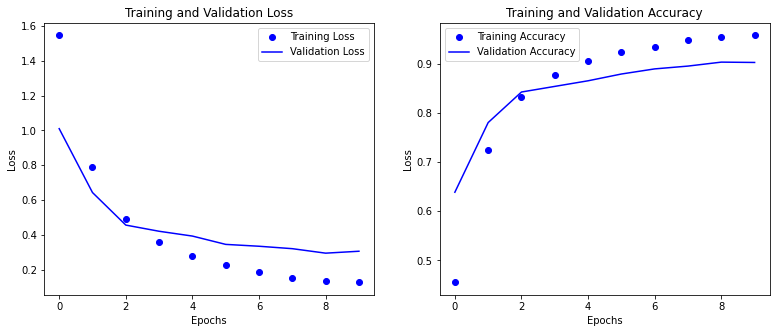

In [19]:

acc = history_spec.history['accuracy']
val_acc = history_spec.history['val_accuracy']

loss=history_spec.history['loss']
val_loss=history_spec.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(13, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, 'bo', label='Training Loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')


plt.subplot(1, 2, 2)
plt.plot(epochs_range, acc, 'bo', label='Training Accuracy')
plt.plot(epochs_range, val_acc, 'b', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()

In [20]:
model_spec.load_weights(checkpoint_dir)

In [21]:
results = model_spec.evaluate(test_dataset)

94/94 [==============================] - 20s 212ms/step - loss: 0.2931 - accuracy: 0.9040


In [22]:
# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))

loss value: 0.293
accuracy value: 90.4000%


In [23]:
X_test_re = X_test.reshape([-1, sr, sc])
X_test_re.shape

(3000, 130, 126)

In [24]:
#학습 다 시킨 데이터들은 다시 1차원으로 바꿔줘야 함

def spec2wav(wav):
    D = np.abs(librosa.istft(wav))
    return D
data_wav = []
for spec in X_test_re:
    data_wav.append(spec2wav(spec))
data_wav = np.array(data_wav)
data_wav.shape

(3000, 8000)

In [25]:
data_wav

array([[3.15706857e-05, 2.56196872e-05, 1.55839371e-05, ...,
        5.57602107e-05, 3.21079860e-05, 3.94772615e-05],
       [3.00471496e-04, 2.76281789e-04, 3.03910987e-04, ...,
        9.20742696e-06, 2.74093054e-05, 3.63038780e-05],
       [1.01659243e-04, 1.03805549e-04, 1.27276391e-04, ...,
        3.58195007e-06, 4.33011564e-06, 6.43984313e-05],
       ...,
       [1.09996254e-04, 4.77341346e-05, 1.24852268e-05, ...,
        2.30494661e-05, 2.82034343e-05, 2.57348693e-05],
       [1.15442253e-05, 2.34358995e-05, 1.66906266e-05, ...,
        3.32462077e-05, 3.51729541e-05, 3.28608949e-05],
       [2.30198842e-03, 1.65864022e-03, 1.42012344e-04, ...,
        8.42897512e-04, 3.41478124e-04, 1.21725153e-03]], dtype=float32)

In [26]:
inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(X_test_re), size=1, replace=False)

batch_xs = X_test_re[batch_index]
batch_ys = y_test[batch_index]
y_pred_ = model_spec(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_xs.reshape(sr*sc), rate=sr*sc)

label :  left


In [27]:
if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')

y_pred: left(Correct!)


# 1-2. skip connection 1D

In [28]:
input_tensor = layers.Input(shape=(sr, sc))

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
skip_1 = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(skip_1)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_1], -1)
skip_2 = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(skip_2)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_2], -1)
skip_3 = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(skip_3)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_3], -1)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_spec_skip = tf.keras.Model(input_tensor, output_tensor)

model_spec_skip.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 130, 126)]   0                                            
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 130, 32)      36320       input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 130, 32)      9248        conv1d_10[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_4 (MaxPooling1D)  (None, 65, 32)       0           conv1d_11[0][0]                  
____________________________________________________________________________________________

In [29]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_spec_skip.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])

In [30]:
# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/E05_SpeechToText/models/wav_skip'

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

In [31]:
history_spec_skip = model_spec_skip.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(X_train) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(X_test) // batch_size,
                    callbacks=[cp_callback]
                    )

Epoch 1/10
840/843 [============================>.] - ETA: 0s - loss: 1.6222 - accuracy: 0.4378
Epoch 00001: val_loss improved from inf to 1.06547, saving model to /home/ssac18/aiffel/E05_SpeechToText/models/wav_skip
843/843 [==============================] - 6s 8ms/step - loss: 1.6208 - accuracy: 0.4385 - val_loss: 1.0655 - val_accuracy: 0.6280
Epoch 2/10
836/843 [============================>.] - ETA: 0s - loss: 0.8875 - accuracy: 0.6925
Epoch 00002: val_loss improved from 1.06547 to 0.65997, saving model to /home/ssac18/aiffel/E05_SpeechToText/models/wav_skip
843/843 [==============================] - 6s 7ms/step - loss: 0.8858 - accuracy: 0.6928 - val_loss: 0.6600 - val_accuracy: 0.7742
Epoch 3/10
836/843 [============================>.] - ETA: 0s - loss: 0.5516 - accuracy: 0.8112
Epoch 00003: val_loss improved from 0.65997 to 0.44435, saving model to /home/ssac18/aiffel/E05_SpeechToText/models/wav_skip
843/843 [==============================] - 7s 8ms/step - loss: 0.5506 - accurac

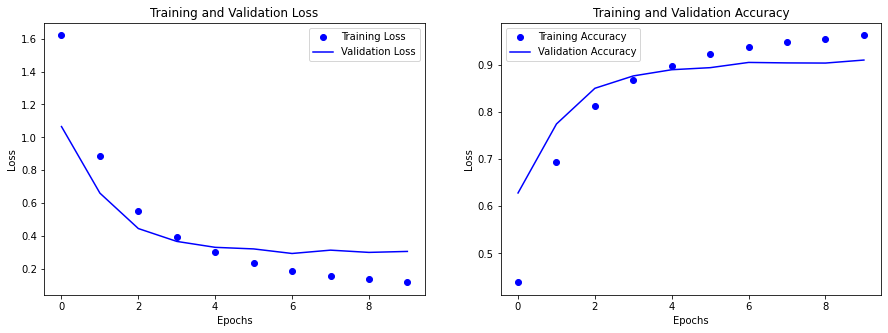

In [32]:
acc = history_spec_skip.history['accuracy']
val_acc = history_spec_skip.history['val_accuracy']

loss=history_spec_skip.history['loss']
val_loss=history_spec_skip.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, 'bo', label='Training Loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')


plt.subplot(1, 2, 2)
plt.plot(epochs_range, acc, 'bo', label='Training Accuracy')
plt.plot(epochs_range, val_acc, 'b', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()

In [33]:
model_spec_skip.load_weights(checkpoint_dir)
results = model_spec_skip.evaluate(test_dataset)

# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))


94/94 [==============================] - 5s 55ms/step - loss: 0.2933 - accuracy: 0.9033
loss value: 0.293
accuracy value: 90.3333%


In [34]:
X_test_re = X_test.reshape([-1, sr, sc])
X_test_re.shape

(3000, 130, 126)

In [35]:
def spec2wav(wav):
    D = np.abs(librosa.istft(wav))
    return D
data_wav = []
for spec in X_test_re:
    data_wav.append(spec2wav(spec))
data_wav = np.array(data_wav)
data_wav.shape

(3000, 8000)

In [36]:
# Test 

inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(X_test_re), size=1, replace=False)

batch_xs = X_test_re[batch_index]
batch_ys = y_test[batch_index]
y_pred_ = model_spec_skip(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_xs.reshape(sr*sc), rate=sr*sc)

label :  left


In [37]:
if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')


y_pred: left(Correct!)


# 2-1. Spectrogram Classification - Conv2D 사용

In [65]:
from tensorflow.keras import layers

input_tensor = layers.Input(shape=(sr, sc, 1))   

x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(input_tensor)
x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(x)
x = layers.MaxPool2D(padding='same')(x)

x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
x = layers.MaxPool2D(padding='same')(x)

x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
x = layers.MaxPool2D(padding='same')(x)

x = layers.Conv2D(256, (3,3), padding='same', activation='relu')(x)
x = layers.Conv2D(256, (3,3), padding='same', activation='relu')(x)
x = layers.Conv2D(256, (3,3), padding='same', activation='relu')(x)
x = layers.MaxPool2D(padding='same')(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)             # 최종 출력은 12차원. 타겟 개수가 12개니까!

model_spec = tf.keras.Model(input_tensor, output_tensor)

model_spec.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 130, 126, 1)]     0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 130, 126, 32)      320       
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 130, 126, 32)      9248      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 65, 63, 32)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 65, 63, 64)        18496     
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 65, 63, 64)        36928     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 33, 32, 64)        0   

In [66]:
optimizer=tf.keras.optimizers.Adam(1e-4)          # adam optimizer 
model_spec.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),       # categorical loss
             optimizer=optimizer,
             metrics=['accuracy'])

In [67]:
# 모델 가중치를 저장
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

In [68]:
history_spec = model_spec.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(X_train) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(X_test) // batch_size,
                    callbacks=[cp_callback]
                    )

Epoch 1/10
842/843 [============================>.] - ETA: 0s - loss: 0.7357 - accuracy: 0.7601
Epoch 00001: val_loss improved from inf to 0.29324, saving model to /home/ssac18/aiffel/E05_SpeechToText/models/wav_skip
843/843 [==============================] - 40s 47ms/step - loss: 0.7353 - accuracy: 0.7602 - val_loss: 0.2932 - val_accuracy: 0.9012
Epoch 2/10
842/843 [============================>.] - ETA: 0s - loss: 0.2207 - accuracy: 0.9309
Epoch 00002: val_loss improved from 0.29324 to 0.16114, saving model to /home/ssac18/aiffel/E05_SpeechToText/models/wav_skip
843/843 [==============================] - 39s 46ms/step - loss: 0.2208 - accuracy: 0.9309 - val_loss: 0.1611 - val_accuracy: 0.9533
Epoch 3/10
843/843 [==============================] - ETA: 0s - loss: 0.1308 - accuracy: 0.9612
Epoch 00003: val_loss did not improve from 0.16114
843/843 [==============================] - 38s 46ms/step - loss: 0.1308 - accuracy: 0.9612 - val_loss: 0.1635 - val_accuracy: 0.9432
Epoch 4/10
843/8

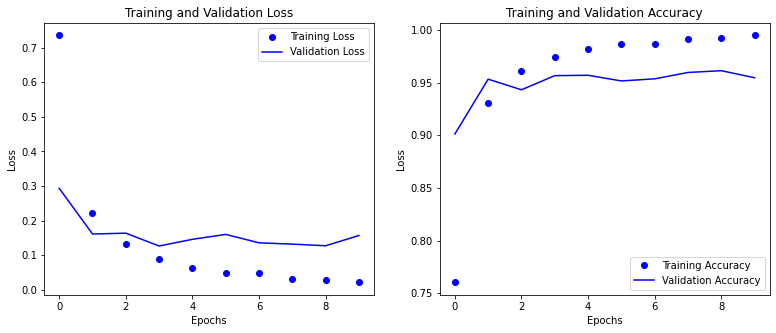

In [69]:
acc = history_spec.history['accuracy']
val_acc = history_spec.history['val_accuracy']

loss=history_spec.history['loss']
val_loss=history_spec.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(13, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, 'bo', label='Training Loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')


plt.subplot(1, 2, 2)
plt.plot(epochs_range, acc, 'bo', label='Training Accuracy')
plt.plot(epochs_range, val_acc, 'b', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()


#### evaluation

In [70]:
model_spec.load_weights(checkpoint_dir)

In [71]:
results = model_spec.evaluate(test_dataset)

94/94 [==============================] - 1s 15ms/step - loss: 0.1264 - accuracy: 0.9570


In [72]:
# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))

loss value: 0.126
accuracy value: 95.7000%


#### Model set

In [73]:
X_test_re = X_test.reshape([-1, sr, sc])
X_test_re.shape

(3000, 130, 126)

In [74]:
def spec2wav(wav):
    D = np.abs(librosa.istft(wav))
    return D
data_wav = []
for spec in X_test_re:
    data_wav.append(spec2wav(spec))
data_wav = np.array(data_wav)
data_wav.shape

(3000, 8000)

In [75]:
inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(X_test_re), size=1, replace=False)

batch_xs = X_test_re[batch_index]
batch_ys = y_test[batch_index]
y_pred_ = model_spec(batch_xs.reshape([-1,sr,sc,1]), training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_xs.reshape(sr*sc), rate=sr*sc)

label :  left


In [76]:
if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')

y_pred: left(Correct!)


# 2-2. Skip Connection Model ver. - Conv2D

In [55]:
input_tensor = layers.Input(shape=(sr, sc, 1))

x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(input_tensor)
x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(x)
skip_1 = layers.MaxPool2D(padding='same')(x)

x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(skip_1)
x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
x = tf.concat([x, skip_1], -1)
skip_2 = layers.MaxPool2D(padding='same')(x)

x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(skip_2)
x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
x = tf.concat([x, skip_2], -1)
skip_3 = layers.MaxPool2D(padding='same')(x)

x = layers.Conv2D(256, (3,3), padding='same', activation='relu')(skip_3)
x = layers.Conv2D(256, (3,3), padding='same', activation='relu')(x)
x = layers.Conv2D(256, (3,3), padding='same', activation='relu')(x)
x = tf.concat([x, skip_3], -1)
x = layers.MaxPool2D(padding='same')(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_spec_skip = tf.keras.Model(input_tensor, output_tensor)

model_spec_skip.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 130, 126, 1) 0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 130, 126, 32) 320         input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 130, 126, 32) 9248        conv2d_20[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 65, 63, 32)   0           conv2d_21[0][0]                  
____________________________________________________________________________________________

In [56]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_spec_skip.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])

In [57]:
# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/E05_SpeechToText/models/wav_skip'

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

In [58]:
history_spec_skip = model_spec_skip.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(X_train) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(X_test) // batch_size,
                    callbacks=[cp_callback]
                    )

Epoch 1/10
842/843 [============================>.] - ETA: 0s - loss: 0.9144 - accuracy: 0.7024
Epoch 00001: val_loss improved from inf to 0.32147, saving model to /home/ssac18/aiffel/E05_SpeechToText/models/wav_skip
843/843 [==============================] - 44s 52ms/step - loss: 0.9138 - accuracy: 0.7026 - val_loss: 0.3215 - val_accuracy: 0.8978
Epoch 2/10
843/843 [==============================] - ETA: 0s - loss: 0.2728 - accuracy: 0.9156 ETA: 0s - loss:
Epoch 00002: val_loss improved from 0.32147 to 0.19012, saving model to /home/ssac18/aiffel/E05_SpeechToText/models/wav_skip
843/843 [==============================] - 45s 53ms/step - loss: 0.2728 - accuracy: 0.9156 - val_loss: 0.1901 - val_accuracy: 0.9425
Epoch 3/10
843/843 [==============================] - ETA: 0s - loss: 0.1695 - accuracy: 0.9488
Epoch 00003: val_loss did not improve from 0.19012
843/843 [==============================] - 44s 53ms/step - loss: 0.1695 - accuracy: 0.9488 - val_loss: 0.1951 - val_accuracy: 0.9351


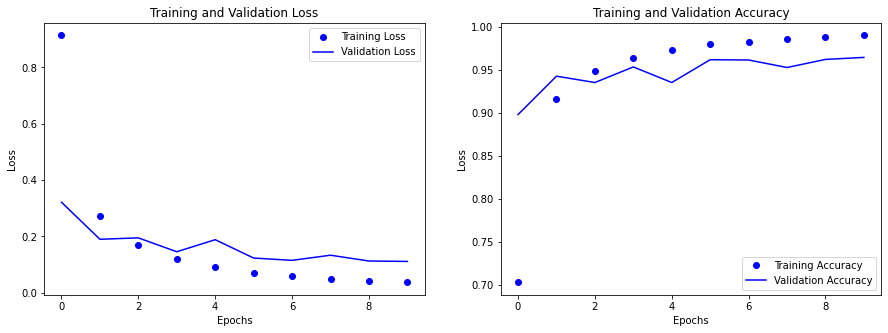

In [59]:
import matplotlib.pyplot as plt

acc = history_spec_skip.history['accuracy']
val_acc = history_spec_skip.history['val_accuracy']

loss=history_spec_skip.history['loss']
val_loss=history_spec_skip.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, 'bo', label='Training Loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')


plt.subplot(1, 2, 2)
plt.plot(epochs_range, acc, 'bo', label='Training Accuracy')
plt.plot(epochs_range, val_acc, 'b', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()

In [60]:
# Evaluation 
model_spec_skip.load_weights(checkpoint_dir)
results = model_spec_skip.evaluate(test_dataset)

# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))


94/94 [==============================] - 8s 88ms/step - loss: 0.1111 - accuracy: 0.9643
loss value: 0.111
accuracy value: 96.4333%


In [61]:
X_test_re = X_test.reshape([-1, sr, sc])
X_test_re.shape

(3000, 130, 126)

In [62]:
def spec2wav(wav):
    D = np.abs(librosa.istft(wav))
    return D
data_wav = []
for spec in X_test_re:
    data_wav.append(spec2wav(spec))
data_wav = np.array(data_wav)
data_wav.shape

(3000, 8000)

In [63]:
# Test 

inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(X_test_re), size=1, replace=False)

batch_xs = X_test_re[batch_index]
batch_ys = y_test[batch_index]
y_pred_ = model_spec_skip(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_xs.reshape(sr*sc), rate=sr*sc)

label :  go


In [64]:
if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')


y_pred: go(Correct!)


### [결과 및 회고]



총 4개의 모델
* __conv1d__   
* __conv1d skip connection__  
* __conv2d__   
* __conv2d skip connection__    

를 사용하여 2차원 스펙트로그램 데이터를 분석했습니다. 모든 모델들의 하이퍼파라미터는 동일하게 부여하였고 (batch size = 32, epoch = 10, regularization-dropout1번,batchnorm 1번, layer 구성 등) 모델의 종류만 다르게 하여 비교해 보았습니다.   
결과를 비교해보면, Conv2D를 활용한 모델이 Conv1D를 활용한 모델 보다 5%이상의 정확도 향상을 보였고 일반 Classification보다는 skip connection 모델이 약소하지만 더 높은 정확도를 보였습니다. 하이퍼파라미터를 모두 동일하게 한 기본적 이유는 4가지 모델 자체의 성능을 비교해보기 위해서이긴 하나 4 모델의 accuracy가 전반적으로 높았기 때문에 다른 경우는 고려하지 않았습니다. 컴퓨터 성능이나 시간을 고려했을 때 epoch이나 batch size를 더욱 크게 하는 것은 무리가 있기 때문에 다른 하이퍼파라미터들을 바꿔주어야 한다면 drop out 층을 추가하거나 L2 norm 정규화를 추가해보는 것도 좋을 것 같습니다.   

결과적으로 모든 모델이 75% 이상의 accuracy를 보였고, 그중에서도 가장 좋은 모델은    
__loss: 0.1111, accuracy: 0.9643__ 의 결과를 보여준 '__Conv2D Skip Connection 모델__ '이었습니다.  


이번 프로젝트를 통해 음성 데이터를 텍스트로 변환하는 과정에 대해 배울 수 있었습니다. 신기하고 재미있긴 했으나... 이번 프로젝트도 역시 쉽지 않았습니다. 음성 데이터를 이해하고 원리를 알기 위해 기초 강의를 듣기도 했지만 아직도 잘 모르겠습니다.. 가장 힘들었던 부분은 데이터의 shape를 파악하는 것입니다. 모델에 알맞은 shape로 만들고, 다시 변형하고 하는 것이 익숙치 않았습니다.   
그러다보니 마지막에 스펙트로그램으로 변환한 데이터를 다시 wave 형태로 변환하여 음성을 확인해보고 싶었는데 결국 되돌리지 못했습니다. data_wav의 shape이 (3000, 8000)으로 나타났고, 이를 모델에 적용하려면 다시 4차원의 형태로 변환해주어야 하는데 실패했습니다. 그렇지만 그것 이외의 과정은 잘 마쳐 모델을 성공적으로 돌릴 수 있었고 전반적으로 높은 accuracy를 낼 수 있었습니다.